In [3]:
import pandas as pd
import networkx as nx
import re
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2 as FA2 # pip install fa2
from heapq import nlargest
from operator import itemgetter
import operator
import numpy as np
import community # pip install python-louvain
import random
import io
import unicodedata
import unidecode # pip install Unidecode
from wordcloud import WordCloud # pip install wordcloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import math
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fpegios\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fpegios\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 2 - What do republican and democratic members tweet about?

**Exercise 4 - TF-IDF of the republican and democratic tweets**

We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below:

* Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.
* Exclude all twitter handles.
* Exclude punctuation.
* Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
* Exclude numbers (since they're difficult to interpret in the word cloud).
* Set everything to lower case.
* Compute the TF-IDF for each document.
* Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics? Why? Comment on the results.            

In [3]:
df2 = pd.read_csv('./115_tw_2019.csv', encoding = "utf-8") # read file with twitter and party associated
RepublicanDocument = "" # create document for republican tweets which is a big string
DemocraticDocument = ""# create document for democratic tweets which is a big string

count_demo = 0 #counter of democratic politician
count_rep = 0 #counter of republican politician

for value in df2.values:
    name = value[0]
    party = value[1]

    with io.open("./tweets_2019_full/" + name, "r", encoding="utf-8") as f:
        tweets = f.read() 
        
    tweets = unicodedata.normalize('NFKD', tweets).encode('ascii','ignore') # unicode to string
    tweets = tweets.decode('utf-8')
    
    tweets = re.sub(r"http\S+", "", tweets) # clear all links
    tweets = re.sub(r"@\S+", "", tweets) # clear all user name
    tweets = re.sub(r'\W+', ' ', tweets) # clear all ponctuation

    if party == "Democratic":
        count_demo += 1 # count number of democratic
        DemocraticDocument += tweets # append tweets from the current reached file
    else:
        count_rep +=1
        RepublicanDocument += tweets

print('done')

done


In [5]:
# compute Term frequency for each document
from nltk import word_tokenize

# function which take a nltk.Text in parameter and return list of tuple(tokens, occurrence)
def countWord(text):
    fdist = nltk.FreqDist([w.lower() for w in text])
    words = []

    for key in fdist.keys():
        if key not in nltk.corpus.stopwords.words() and key.lower().isalpha(): # transform in lower case and drop numbers
            words.append((fdist[key], key))
    words = sorted(words, reverse=True)
    return words

#Democratic
DemocraticDocumentString = ''

# for value in DemocraticDocument:
#     DemocraticDocumentString = DemocraticDocumentString + str(' ' + value)
    
tokens = nltk.word_tokenize(DemocraticDocument) # tokenize the document 
DemocraticDocument = nltk.Text(tokens) # create Text with the list of token
demo_tockens = countWord(DemocraticDocument) # count occurs
print('done demo')

#Republican
RepublicanDocumentString = ''

# for value in RepublicanDocument:
#     RepublicanDocumentString = RepublicanDocumentString + str(' ' + value)

tokens = nltk.word_tokenize(RepublicanDocument)
RepublicanDocument = nltk.Text(tokens)
repu_tockens = countWord(RepublicanDocument)
print('done repu')

done demo
done repu


In [6]:
# compute Inverse document frequency for each document
demo_idf = {}
repu_idf = {}

# republican
for count, word in repu_tockens:
    repu_idf[word] = math.log10(float(count_rep) / float(count))

# democratic
for count, word in demo_tockens:
    demo_idf[word] = math.log10(float(count_rep) / float(count))

In [7]:
# cast list of tuple to dict 
repu_tockens_dict = {}
for i in range(len(repu_tockens)):
    repu_tockens_dict[repu_tockens[i][1]]= repu_tockens[i][0]

demo_tockens_dict = {}
for i in range(len(demo_tockens)):
    demo_tockens_dict[demo_tockens[i][1]]= demo_tockens[i][0]

In [8]:
# compute Term frequency–Inverse document frequency
demo_tfidf = {}
repu_tfidf = {}

for key, value in repu_idf.items():
    repu_tfidf[key] = repu_tockens_dict[key] * repu_idf[key]

for key, value in demo_idf.items():
    demo_tfidf[key] = demo_tockens_dict[key] * demo_idf[key]
    
print('done')

done


In [9]:
# join words into long string

# democrats
demo_words_sorted = sorted(demo_tfidf.items(), key=lambda x: x[1], reverse=True) # make complete sorted list of words
demo_words_string = ""

for pair in demo_words_sorted:
    for i in range(int(math.ceil(pair[1]))):
        demo_words_string += pair[0] + " "

# republicans
repu_words_sorted = sorted(repu_tfidf.items(), key=lambda x: x[1], reverse=True) # make complete sorted list of words
repu_words_string = ""

for pair in repu_words_sorted:
    for i in range(int(math.ceil(pair[1]))):
        repu_words_string += pair[0] + " "

print('done')

done


In [10]:
# Generate a word cloud images

#source: https://stackoverflow.com/a/43043723
def demo_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 150.0 / 255.0) # hue = 150 for blue
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random.randint(40, 180)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def repu_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 0.0 / 255.0) # hue = 0 for red
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random.randint(40, 180)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

# collocations=False to avoid words like "maryland maryland" in the wordcloud
demo_wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(demo_words_string)
repu_wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(repu_words_string)

demo_wordcloud.recolor(color_func=demo_color_func)
repu_wordcloud.recolor(color_func=repu_color_func)

print('done')

done


Now, create word-cloud for each party.

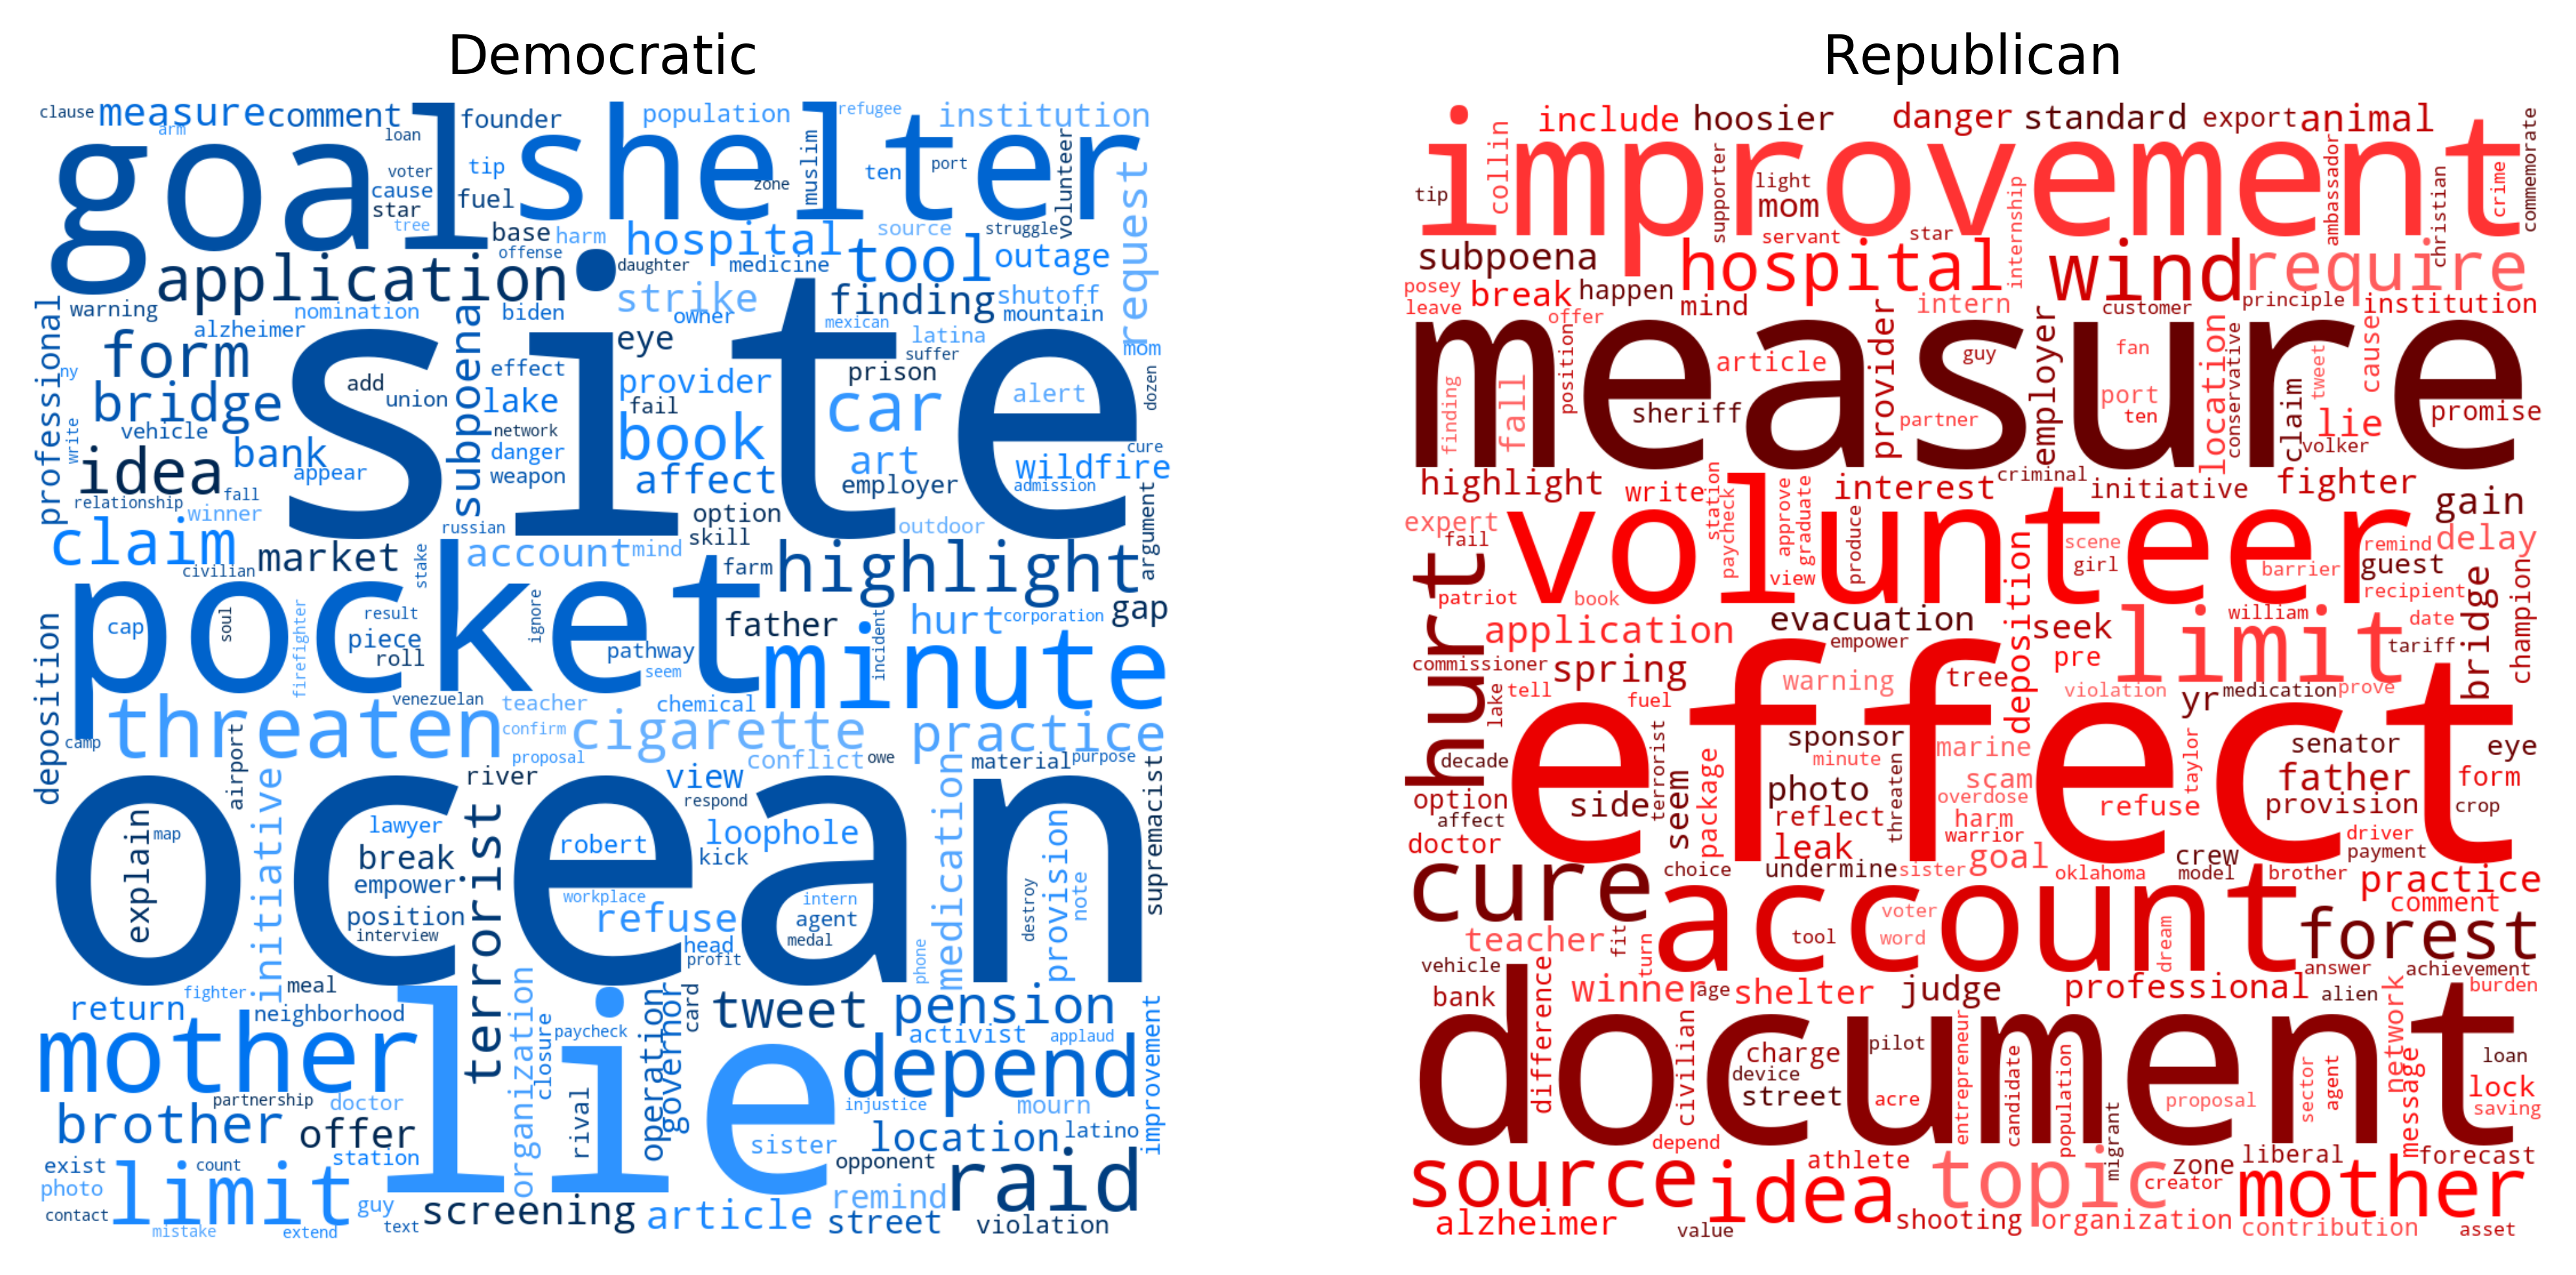

In [11]:
# Display the generated images

# enable plotting in two columns
fig, axs = plt.subplots(ncols=2, figsize=(10, 10), dpi=500)

axs[0].imshow(demo_wordcloud, interpolation='bilinear')
axs[0].set_title("Democratic")
axs[0].axis("off")

axs[1].imshow(repu_wordcloud, interpolation='bilinear')
axs[1].set_title("Republican")
axs[1].axis("off")

plt.show()

Are these topics less "boring" than the wikipedia topics from a few weeks ago? Why? Comment on the results.

Answer: In our opinion, this subject was much more interesting than last topics, because it is about a social network. The result is about politicians and is always cool to see what are the common so words that they use.

## Part 3 - Sentiment analysis

**Exercise 5 - Sentiment over the Twitter data**

* Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.

The list of 10222 words was obtained by merging the top 5000 words according to frequency from each of the four disparate text sources: Twitter, Google Books (English), music lyrics and the New York Times (1987 to 2007). 

The average happiness evaluation for each words was obtained by asking user on Amazon's Mechanical Turk to rate how a given word made them feel (in terms of happiness) on a nine point integer scale. They obtained 50 evaluations per word got the average rating for each word.

In [9]:
# load the labMT word list as a pandas dataframe
labMT = pd.read_csv('./Data_Set_S1_edited.csv', encoding = "utf-8")

In [1]:
# function that calculates sentiment (average happiness) of supplied list of tokens
# only count in words that actually have a value when calculating the average

def calcSentiment(tokenList):
    if len(tokenList) == 0:
        return 0
    else:
        sumValence = 0
        tokensWithValue = 0
        # get the happiness_average value from the labMT list for each token in tokenList
        for token in tokenList:
            if token in labMT.word.values:
                sumValence += labMT.loc[labMT['word'] == token, 'happiness_average'].item() # get the sentiment for the token
                tokensWithValue += 1
        # calculate and return the average of all the happiness_average values
        if tokensWithValue == 0:
            return 0
        else:
            return sumValence / tokensWithValue #len(tokenList)

* Create two lists: one including the tweets written by democratic members, and the other including the tweets written by republican members (in the text files, tweets are separated by newlines).

* Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?

In [5]:
# takes about 30 sec to execute
# make lists of tokenized tweets
demo_tweets = []
repu_tweets = []

for person in df2.values:
    vparty = person[1]
    vname = person[0]
    
    with io.open("./tweets_2019_full/" + vname, "r", encoding="utf-8") as f:
        tweets = f.readlines()
        
    for line in tweets:
        if line.strip():
            
            line = unicodedata.normalize('NFKD', line).encode('ascii','ignore') # unicode to string
            line = line.decode('utf-8')
            
            line = re.sub(r"http\S+", "", line) # clear all links
            line = re.sub(r"@\S+", "", line) # clear all user name
            line = re.sub(r'\W+', ' ', line) # clear all punctuation
            line = re.sub(r'RT ', "", line) # clear all retweet indicators
            line = re.sub(r'\d+(.\d+)?', "", line) # clear all numbers and floats
                     
            tokens = nltk.word_tokenize(line.lower()) # lowercase all words and tokenize and remove numbers
            
            if vparty == 'Democratic': 
                demo_tweets.append(tokens)
            else:
                repu_tweets.append(tokens)
            
print('done')

done


In [10]:
# NB: this takes a long time to run (around 15 min)!
# make list of the sentiment (average happiness) for each tweet by democrats
demo_tweetsValue = [calcSentiment(tweet) for tweet in demo_tweets]
print('demo done')

demo done


In [13]:
# NB: this takes a long time to run (around 15 min)!
# make list of the sentiment (average happiness) for each tweet by republicans
repu_tweetsValue = [calcSentiment(tweet) for tweet in repu_tweets]
print('repu done')

repu done


In [16]:
# create bins for the histogram of tweet sentiment
bins = np.arange(0,max(max(demo_tweetsValue),max(repu_tweetsValue)) + 0.02, 0.01) # add two steps to ensure all data is included in graph

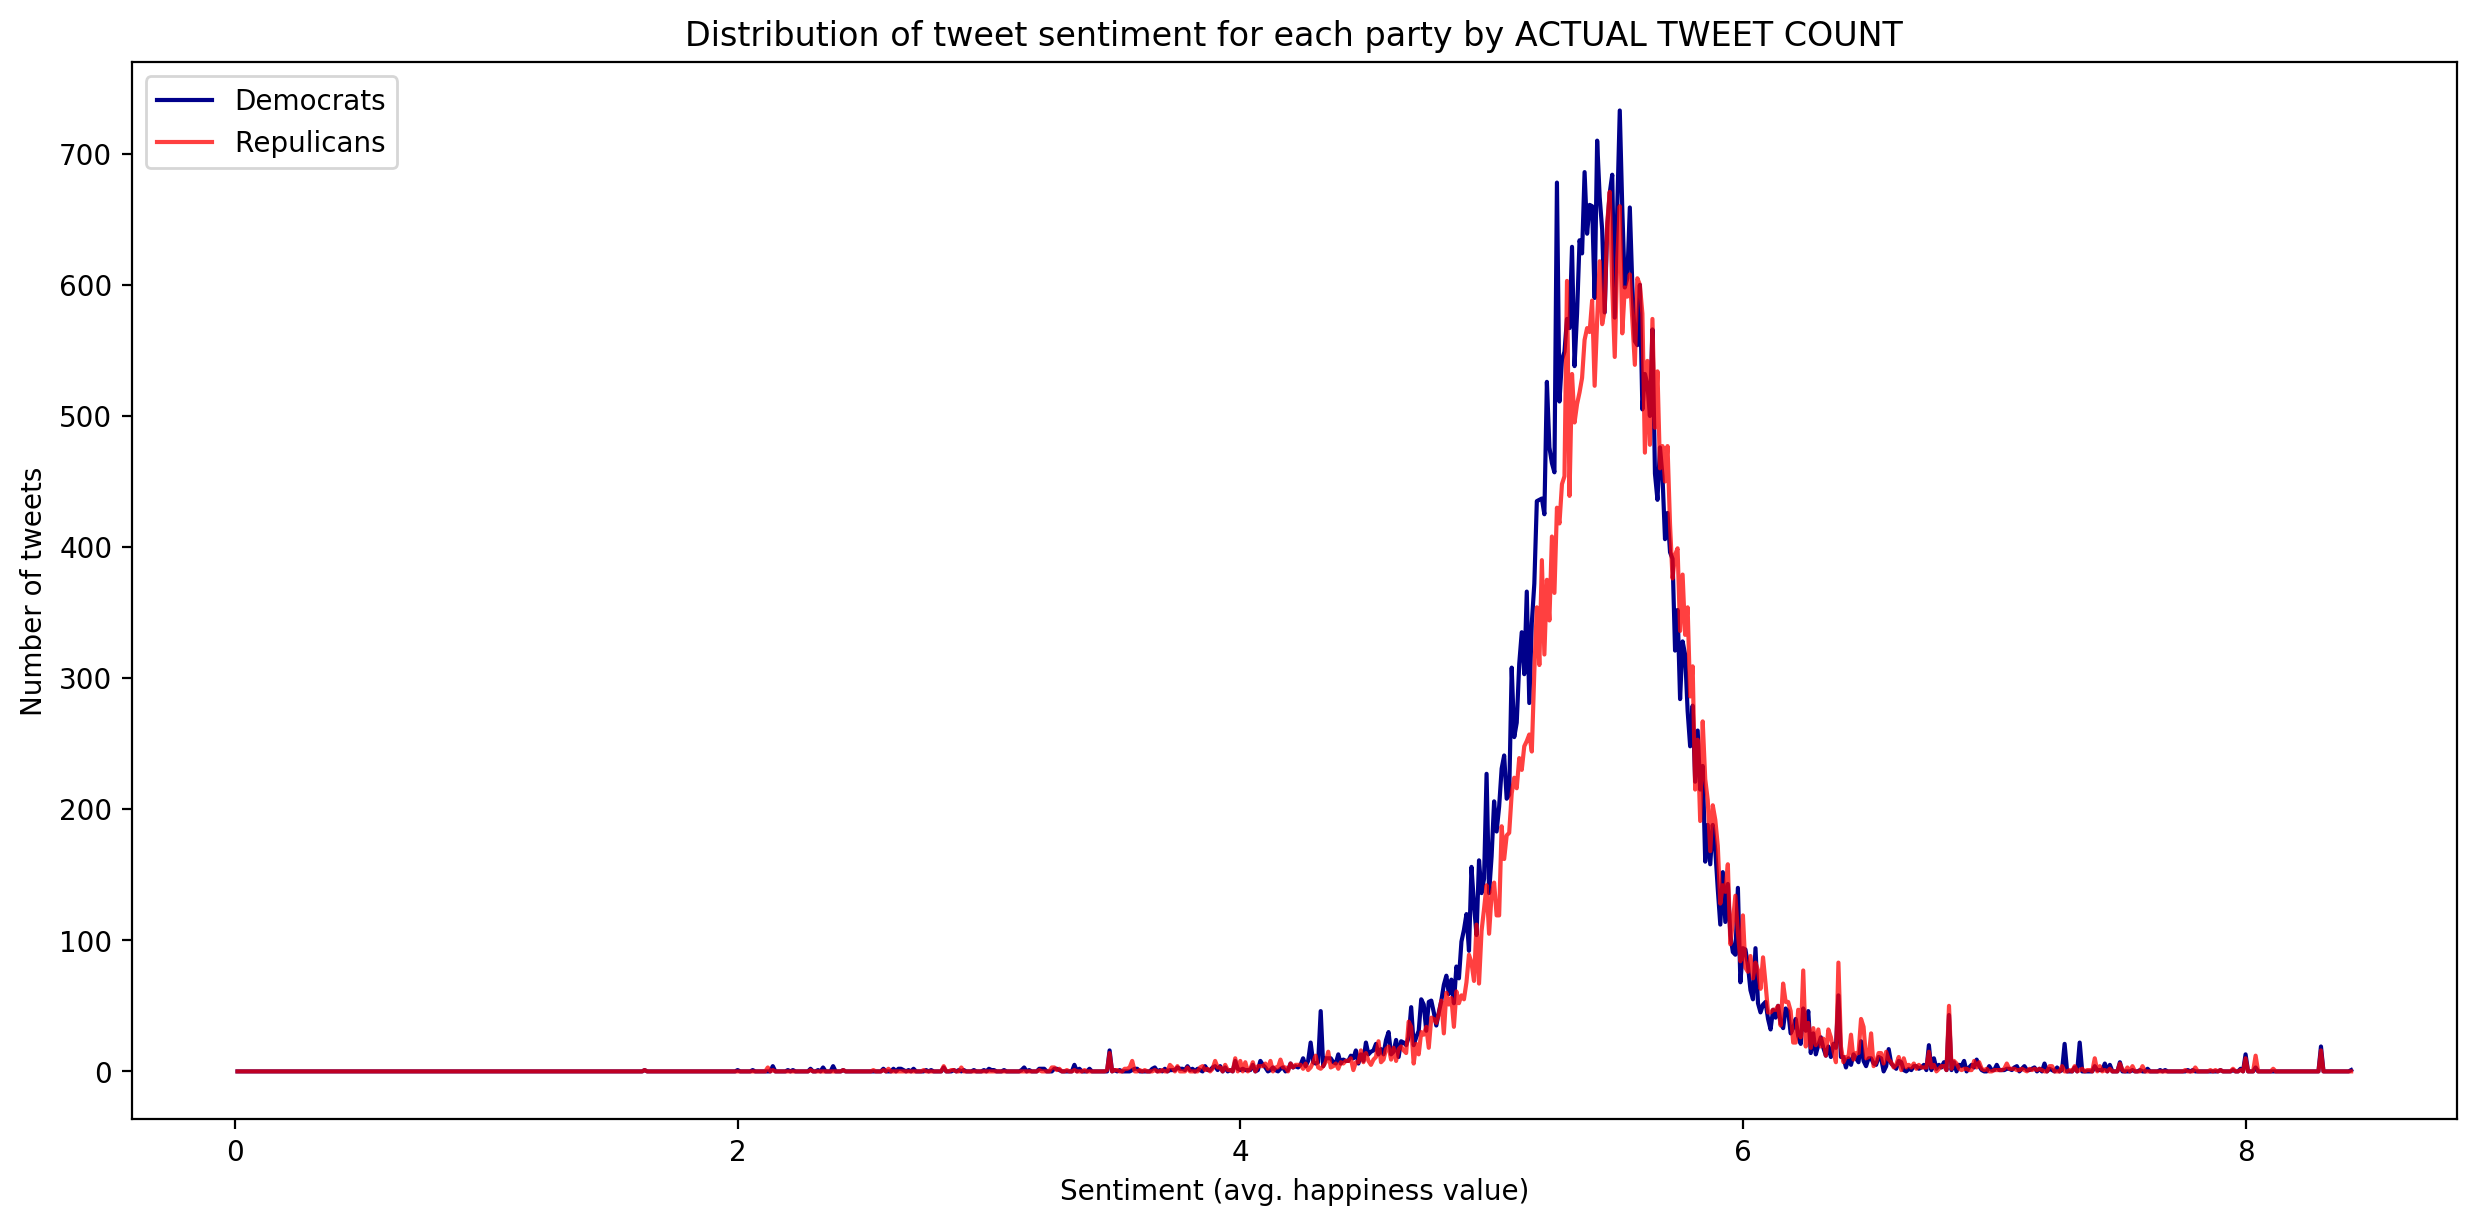

In [17]:
# plot graphs with actual number of tweets for each sentiment value
fig = plt.figure(figsize=(15,7), dpi=200)
ax1 = fig.add_subplot(111)

demo_cnt, i = np.histogram(demo_tweetsValue, bins=bins)
repu_cnt, i = np.histogram(repu_tweetsValue, bins=bins)

# bins[1:] and cnt[1:] to exclude tweets with sentiment = 0 to better show sentiment distribution
ax1.plot(bins[1:len(demo_cnt)], demo_cnt[1:], label='Democrats', color='darkblue', alpha=1)
ax1.plot(bins[1:len(repu_cnt)], repu_cnt[1:], label='Repulicans', color='red', alpha=0.75)

ax1.set_title('Distribution of tweet sentiment for each party by ACTUAL TWEET COUNT')
ax1.set_ylabel('Number of tweets')
ax1.set_xlabel("Sentiment (avg. happiness value)")
plt.legend(loc='upper left');
plt.show()

To normalize the distribution of tokens with each sentiment value and make the distribution across parties more comparable, the fraction of total tokens with the given sentiment value is plotted for each party instead of plotting of the number of actual tokens with each sentiment value.

In [18]:
# data for normalized graphs with fraction of total tweets instead of actual number of tweets
# convert to fraction of N for demo
demo_cnt = [cnt / float(sum(demo_cnt)) for cnt in demo_cnt]
# convert to fraction of N for repu
repu_cnt = [cnt / float(sum(repu_cnt)) for cnt in repu_cnt]

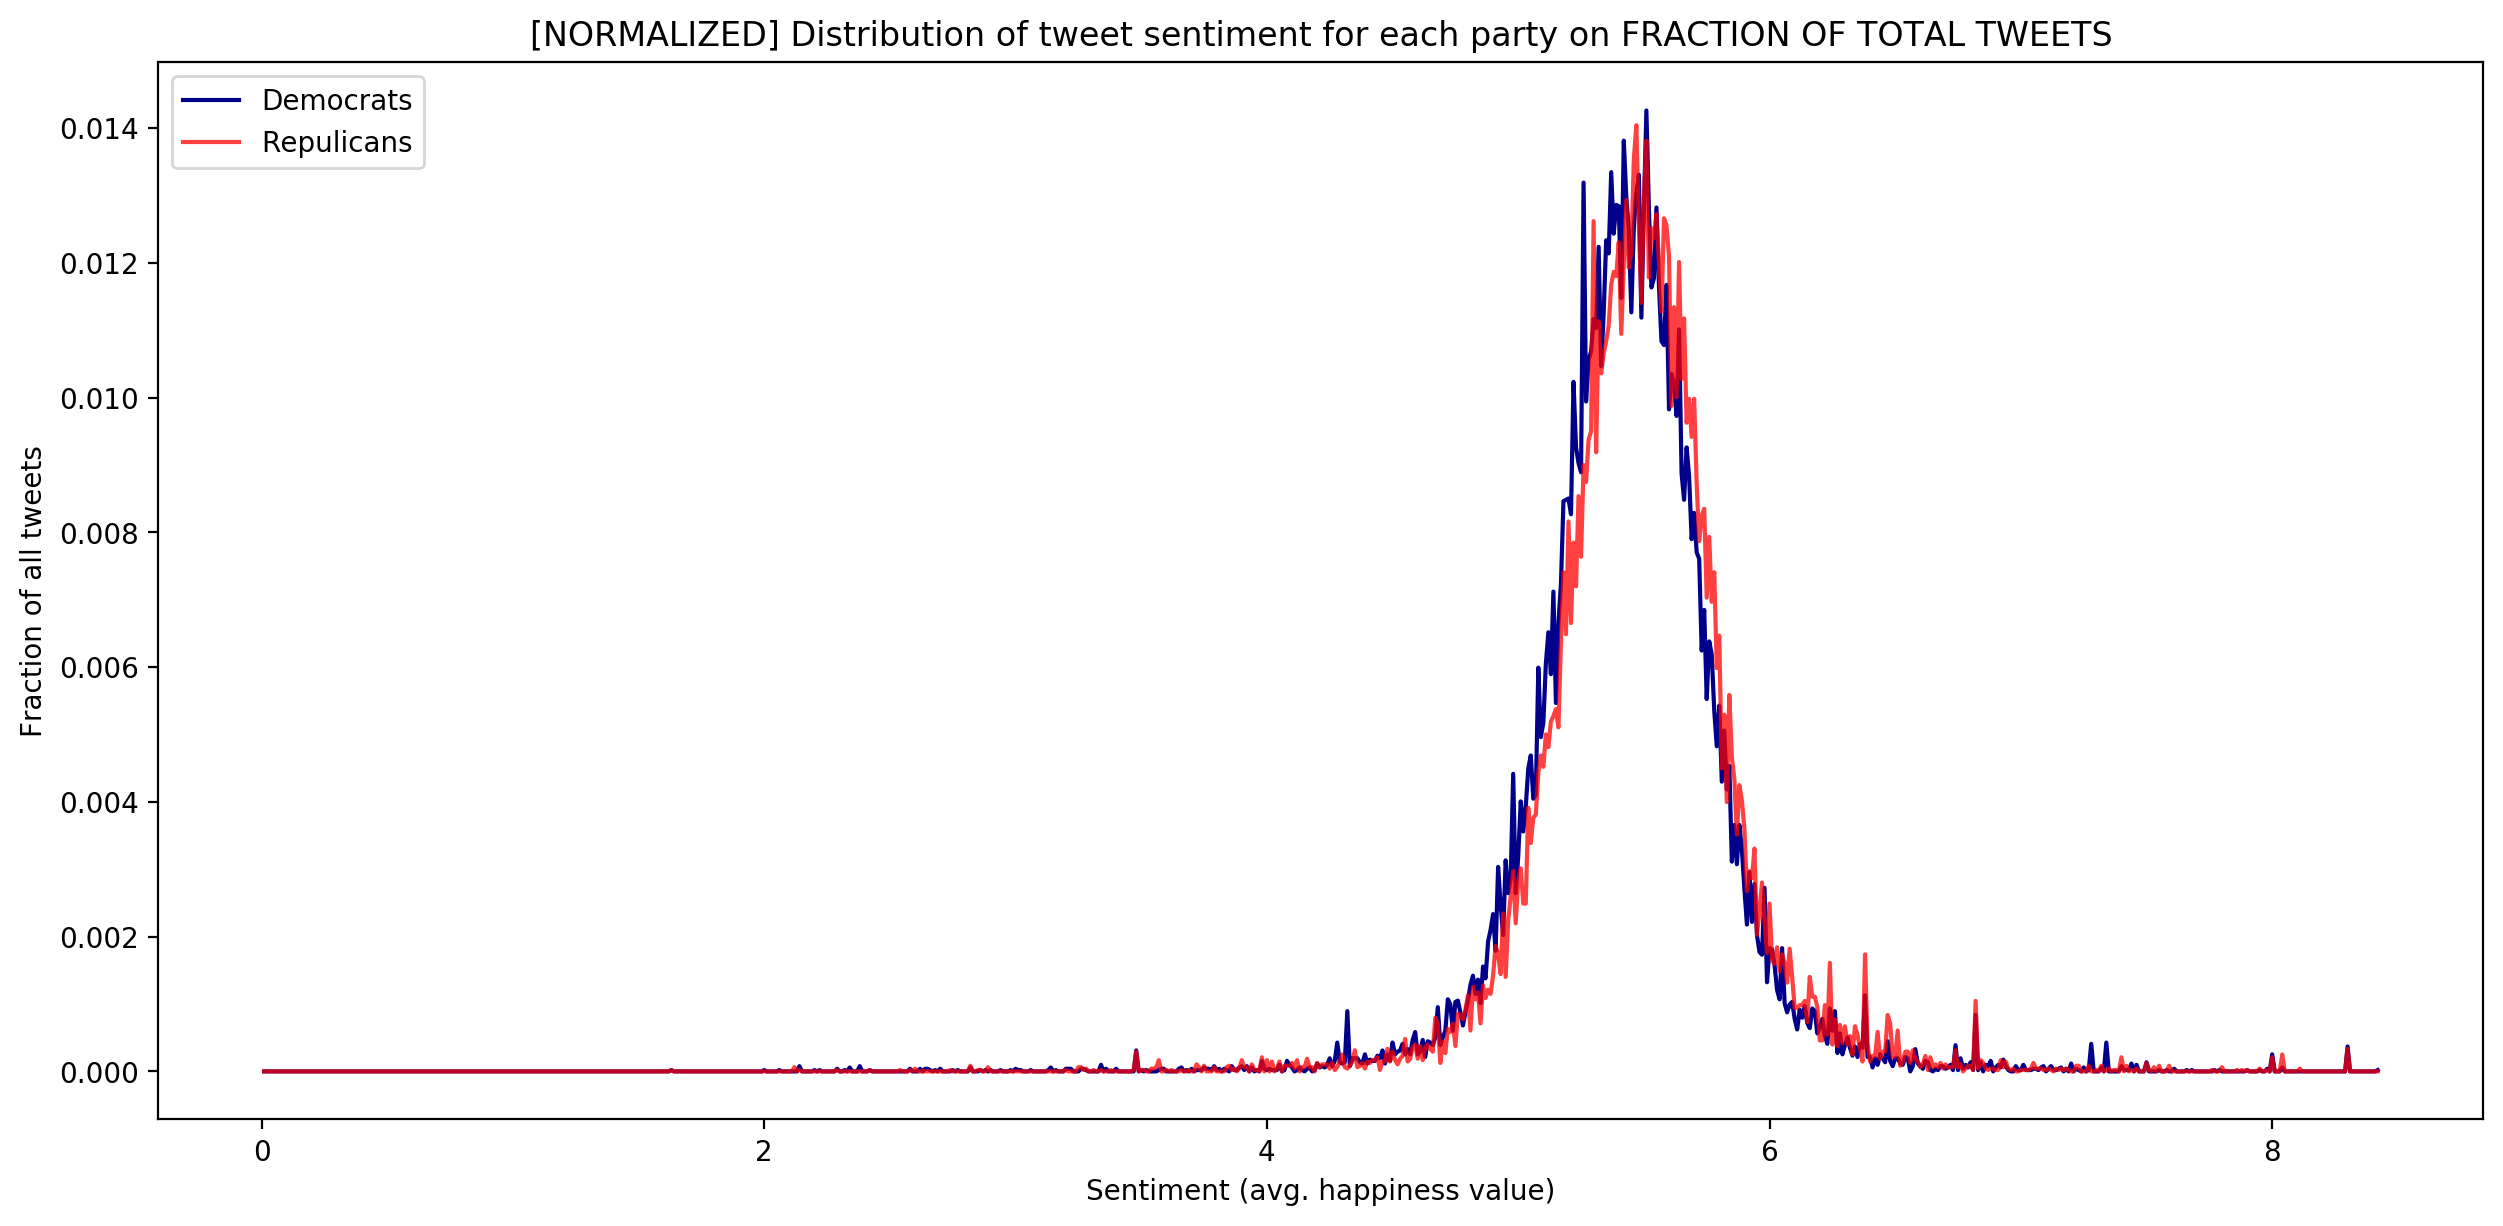

In [19]:
fig = plt.figure(figsize=(15,7), dpi=200)
ax1 = fig.add_subplot(111)

# bins[1:] and cnt[1:] to exclude tweets with sentiment = 0 to better show sentiment distribution
ax1.plot(bins[1:len(demo_cnt)], demo_cnt[1:], label='Democrats', color='darkblue', alpha=1)
ax1.plot(bins[1:len(repu_cnt)], repu_cnt[1:], label='Repulicans', color='red', alpha=0.75)

ax1.set_title('[NORMALIZED] Distribution of tweet sentiment for each party on FRACTION OF TOTAL TWEETS')
ax1.set_ylabel('Fraction of all tweets')
ax1.set_xlabel("Sentiment (avg. happiness value)")
plt.legend(loc='upper left');
plt.show()

Firstly, the normalization provides a noticable difference (e.g. the democratic peak near the sentiment value 5 is noticably taller in the normalized graph than in the first graph), because the total amount of tokens with a sentiment value is higher with the republicans.

Interestingly, the graph for either party seem to peak in the same areas.

In terms of who posts more positive tweets, the parties are very alike. A bigger percentage of the republicans tweets seem to contain slightly more positive words, while democrats post more tweets with lower valence. However, the democrats post more tweets that contain fairly positive words as seen in the local democratic peak around sentiment value = 7, while republicans take the cake in terms of very positive tweets with an average valence above 8.

Compute the average m and standard deviation σ of the tweets sentiment (considering tweets by both republican and democrats).

In [20]:
avgM = np.mean(demo_tweetsValue + repu_tweetsValue)
std = np.std(demo_tweetsValue + repu_tweetsValue)
lower_threshold = avgM - 2*std
upper_threshold = avgM + 2*std

print('average m:')
print(avgM)
print('std deviation:')
print(std)

average m:
4.921473262065157
std deviation:
1.6793819059101889


* Now consider only tweets with sentiment lower than m-2σ. We will refer to them as negative tweets. Build a list containing the negative tweets written by democrats, and one for republicans. Compute the TF-IDF for these two lists (use the same pre-processing steps in Exercise 5). Create a word-cloud for each of them. Are there differences between the positive contents posted by republicans and democrats?

In [49]:
# get tokenized negative tweets
demo_negTokens = []
demo_cnt = 0
demo_docsWithToken = {} # keep track of how many documents have certain token in them - used to calc IDF

# make connection between each tokenized tweet and its sentiment
for info in zip(demo_tweets, demo_tweetsValue):
    tokens = info[0]
    sentVal = info[1]
    
    if 0 < sentVal < lower_threshold:        
        demo_negTokens += tokens
        demo_cnt += 1 # document (tweet) count
        # update dictionary of doc counts for each token - used to get the IDF value
        for token in set(tokens):
            if token in demo_docsWithToken:
                demo_docsWithToken[token] += 1
            else:
                demo_docsWithToken[token] = 1

In [48]:
repu_negTokens = []
repu_cnt = 0
repu_docsWithToken = {} # keep track of how many documents have certain token in them - used to calc IDF

# make connection between each tokenized tweet and its sentiment
for info in zip(repu_tweets, repu_tweetsValue):
    tokens = info[0]
    sentVal = info[1]
    
    if 0 < sentVal < lower_threshold:
        repu_negTokens += tokens
        repu_cnt += 1 # document (tweet) count
        # update dictionary of doc counts for each token - used to get the IDF value
        for token in set(tokens):
            if token in repu_docsWithToken:
                repu_docsWithToken[token] += 1
            else:
                repu_docsWithToken[token] = 1
            
print('done')

done
